# **INFO5731 Assignment 5**

---


**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100

**Full Points will be given those who present well**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

# **SENTIMENT ANALYSIS**

The objective of this assignment is to give you **hands-on experience** in applying various** sentiment analysis techniques** on real-world textual data. You are expected to explore data, apply machine learning models, and evaluate their performance

**1. Dataset Collection & Preparation**

Find a real-world dataset with text and positive, negative, and neutral sentiment labels.

Justify your dataset choice and handle **class imbalance** if needed.

**2. Exploratory Data Analysis (EDA)**

Clean and preprocess the data (tokenization, stopwords, lemmatization).

Perform EDA: class distribution, word clouds, n-gram analysis, sentence lengths, etc.

Visualize insights using relevant plots and charts.

**3. Sentiment Classification**

Apply at least three traditional ML models (e.g., SVM, Naive Bayes, XGBoost) using TF-IDF or embeddings.

If applicable, compare with a pretrained model (RoBERTa/BERT).

Tune hyperparameters and use cross-validation.

**4. Evaluation & Reporting**

Evaluate with metrics: Accuracy, Precision, Recall, F1, Confusion Matrix.

Summarize results, compare models, and reflect on what worked.

In [1]:
!pip install gensim
import re
import nltk
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import kagglehub
from kagglehub import KaggleDatasetAdapter

from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from xgboost import XGBClassifier
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TextClassificationPipeline

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("punkt")
nltk.download("punkt_tab")

url = "https://raw.githubusercontent.com/DhannajayaPaliwal12/Dhananjaya_INFO5731_Fall2025/main/imdb_reviews_annotated.csv"
df = pd.read_csv(url)
print(df.info())
print(df['sentiment'].value_counts())

classes = np.unique(df['sentiment'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['sentiment'])
class_weights = dict(zip(classes, weights))
class_weights

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 35.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   document_id  1000 non-null   int64 
 1   clean_text   1000 non-null   object
 2   sentiment    1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB
None
sentiment
positive    668
negative    326
neutral       6
Name: count, dtype: int64


{'negative': np.float64(1.0224948875255624),
 'neutral': np.float64(55.55555555555556),
 'positive': np.float64(0.499001996007984)}

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

df['processed_text'] = df['clean_text'].apply(preprocess)
df.head()

,document_id,clean_text,sentiment,processed_text
0,1,You'll have to have your wits about you and yo...,positive,youll wit brain fully switched watching oppenh...
1,2,One of the most anticipated films of the year ...,positive,one anticipated film year many people included...
2,3,I'm a big fan of Nolan's work so was really lo...,positive,im big fan nolans work really looking forward ...
3,4,I'm still collecting my thoughts after experie...,positive,im still collecting thought experiencing film ...
4,5,"""Oppenheimer"" is a biographical thriller film ...",positive,oppenheimer biographical thriller film written...


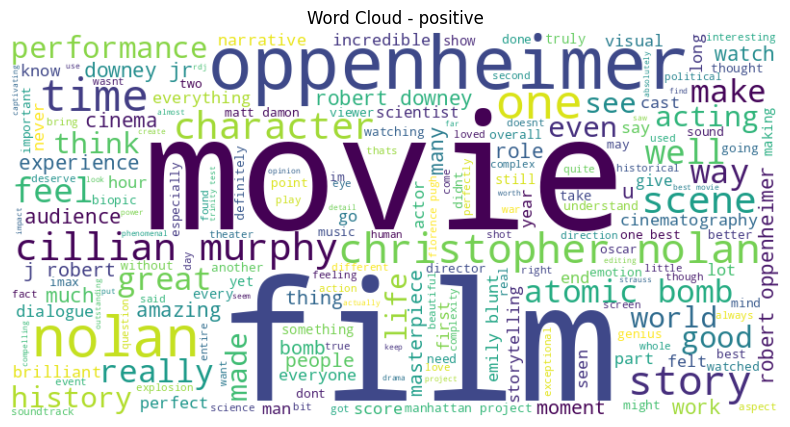

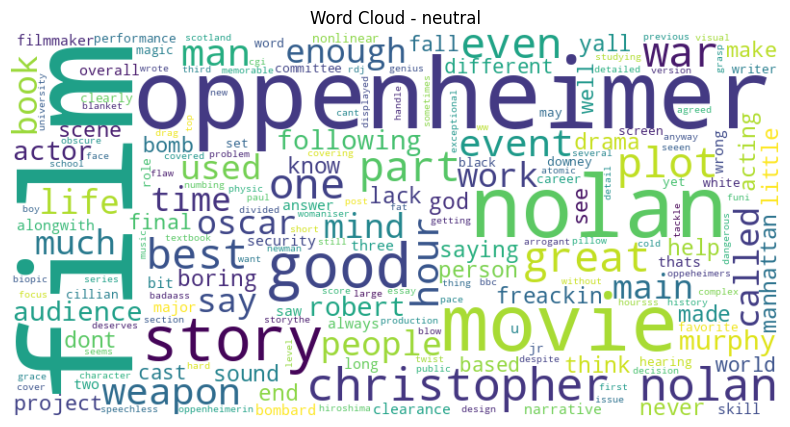

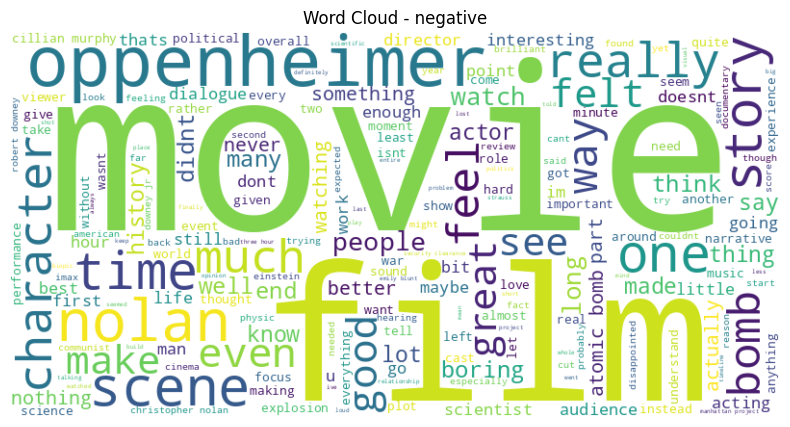

In [3]:
for sentiment in ['positive', 'neutral', 'negative']:
    text = " ".join(df[df['sentiment'] == sentiment]['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud - {sentiment}")
    plt.axis('off')
    plt.show()

In [4]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['processed_text']).toarray()

y = df['sentiment']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} - Evaluation Metrics:\n")
    print(classification_report(y_true, y_pred))
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", acc)

    cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Neg', 'Neu', 'Pos'],
                yticklabels=['Neg', 'Neu', 'Pos'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Naive Bayes - Evaluation Metrics:

              precision    recall  f1-score   support

    negative       1.00      0.17      0.29        65
     neutral       0.00      0.00      0.00         1
    positive       0.71      1.00      0.83       134

    accuracy                           0.72       200
   macro avg       0.57      0.39      0.37       200
weighted avg       0.80      0.72      0.65       200

Accuracy: 0.725


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


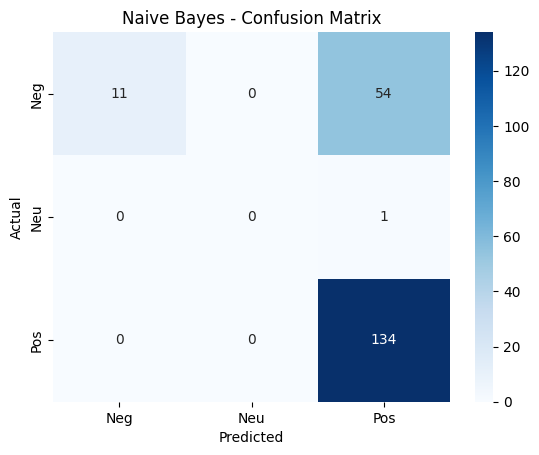

In [7]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
evaluate_model("Naive Bayes", y_test, y_pred_nb)

Best NB Params: {'alpha': 0.1}
Best CV Score: 0.5607023879549204

Naive Bayes (Tuned) - Evaluation Metrics:

              precision    recall  f1-score   support

    negative       0.75      0.75      0.75        65
     neutral       0.00      0.00      0.00         1
    positive       0.87      0.88      0.88       134

    accuracy                           0.83       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.83      0.83      0.83       200

Accuracy: 0.835


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


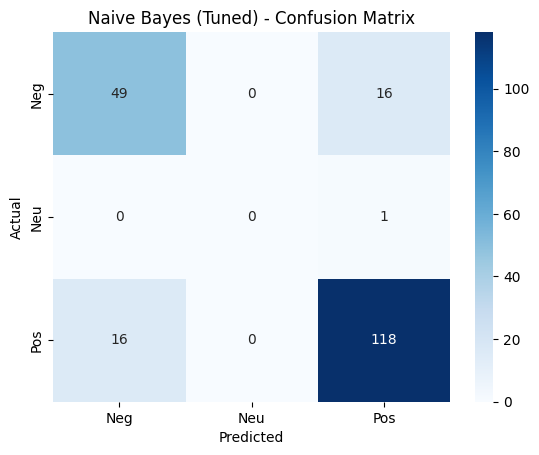

In [8]:
nb_params = {
    "alpha": [0.1, 0.5, 1.0, 2.0]
}

nb_grid = GridSearchCV(
    MultinomialNB(),
    nb_params,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

nb_grid.fit(X_train, y_train)

print("Best NB Params:", nb_grid.best_params_)
print("Best CV Score:", nb_grid.best_score_)

nb_best = nb_grid.best_estimator_
y_pred_nb = nb_best.predict(X_test)
evaluate_model("Naive Bayes (Tuned)", y_test, y_pred_nb)


Random Forest - Evaluation Metrics:

              precision    recall  f1-score   support

    negative       0.78      0.48      0.59        65
     neutral       0.00      0.00      0.00         1
    positive       0.78      0.93      0.85       134

    accuracy                           0.78       200
   macro avg       0.52      0.47      0.48       200
weighted avg       0.78      0.78      0.76       200

Accuracy: 0.78


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


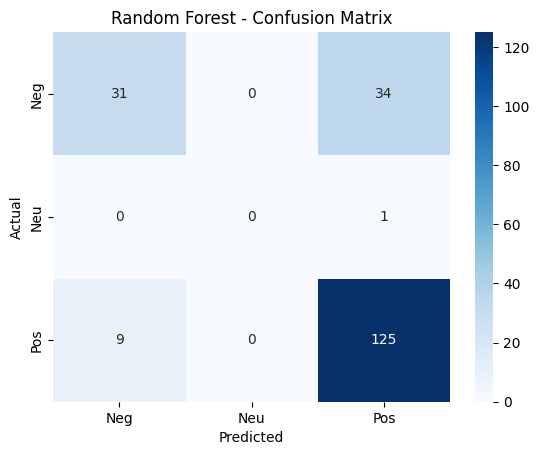

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate_model("Random Forest", y_test, y_pred_rf)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best Random Forest Parameters:
{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best CV F1 Macro Score: 0.5309435754582786

Random Forest (Tuned) - Evaluation Metrics:

              precision    recall  f1-score   support

    negative       0.68      0.74      0.71        65
     neutral       0.00      0.00      0.00         1
    positive       0.87      0.84      0.85       134

    accuracy                           0.80       200
   macro avg       0.51      0.52      0.52       200
weighted avg       0.80      0.80      0.80       200

Accuracy: 0.8


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


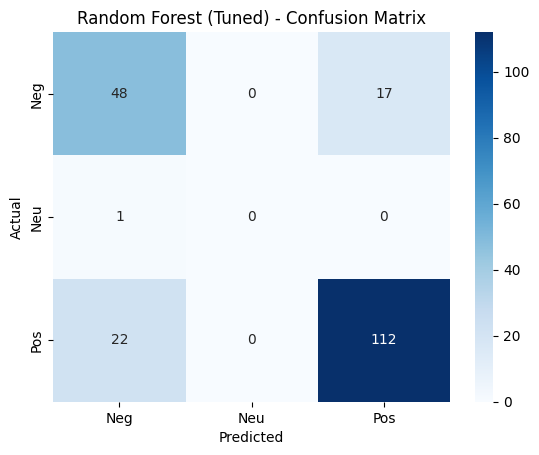

In [10]:
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced", "balanced_subsample"]
}

rf = RandomForestClassifier(random_state=42)

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("\nBest Random Forest Parameters:")
print(rf_grid.best_params_)
print("Best CV F1 Macro Score:", rf_grid.best_score_)

rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)
evaluate_model("Random Forest (Tuned)", y_test, y_pred_rf)


Support Vector Machine - Evaluation Metrics:



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    negative       0.75      0.78      0.77        65
     neutral       0.00      0.00      0.00         1
    positive       0.89      0.87      0.88       134

    accuracy                           0.84       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.84      0.84      0.84       200

Accuracy: 0.84


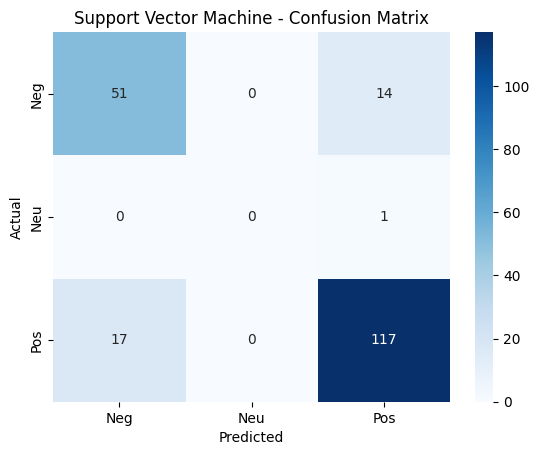

In [11]:
svm = LinearSVC(class_weight='balanced')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

evaluate_model("Support Vector Machine", y_test, y_pred_svm)

Best SVM Parameters: {'C': 1, 'class_weight': 'balanced'}
Best CV Score (macro F1): 0.55998788710631

SVM (Tuned) - Evaluation Metrics:

              precision    recall  f1-score   support

    negative       0.75      0.78      0.77        65
     neutral       0.00      0.00      0.00         1
    positive       0.89      0.87      0.88       134

    accuracy                           0.84       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.84      0.84      0.84       200

Accuracy: 0.84


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


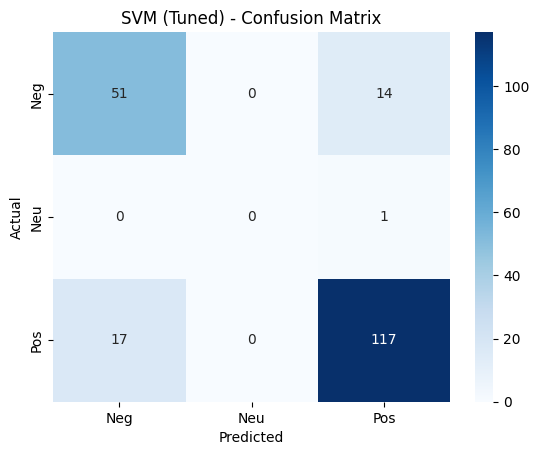

In [12]:
svm_params = {
    "C": [0.01, 0.1, 1, 5, 10],
    "class_weight": ["balanced", None]
}

svm_grid = GridSearchCV(
    LinearSVC(),
    svm_params,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)

print("Best SVM Parameters:", svm_grid.best_params_)
print("Best CV Score (macro F1):", svm_grid.best_score_)

svm_best = svm_grid.best_estimator_
y_pred_svm = svm_best.predict(X_test)
evaluate_model("SVM (Tuned)", y_test, y_pred_svm)

In [13]:
X = df['processed_text']
y = df['sentiment']
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_al

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]


RoBERTa Results:
Accuracy:   0.6950
Precision:  0.5610
Recall:     0.7796
F1-macro:   0.5108

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.60      0.68        65
     neutral       0.03      1.00      0.05         1
    positive       0.88      0.74      0.80       134

    accuracy                           0.69       200
   macro avg       0.56      0.78      0.51       200
weighted avg       0.84      0.69      0.76       200



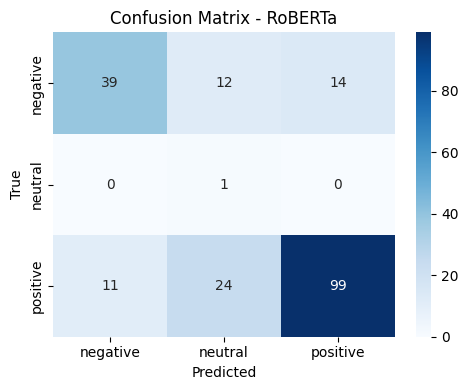

{'model': 'RoBERTa (pretrained)', 'accuracy': 0.695, 'precision_macro': 0.5610444072390975, 'recall_macro': 0.7796019900497514, 'f1_macro': 0.5108372939036555}


In [14]:
roberta_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)

roberta_pipeline = TextClassificationPipeline(
    model=roberta_model,
    tokenizer=tokenizer,
    return_all_scores=False,
    truncation=True,
    max_length=128,
    device=-1
)

y_true_roberta = y_test.values

pred_labels = []

for text in X_test_text:
    pred_label = roberta_pipeline(text)[0]["label"].lower()

    if "neg" in pred_label:
        pred_labels.append("negative")
    elif "neu" in pred_label:
        pred_labels.append("neutral")
    else:
        pred_labels.append("positive")

y_pred_roberta = np.array(pred_labels)

acc = accuracy_score(y_true_roberta, y_pred_roberta)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true_roberta, y_pred_roberta, average="macro", zero_division=0
)
cm = confusion_matrix(y_true_roberta, y_pred_roberta)

print("\nRoBERTa Results:")
print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall:     {rec:.4f}")
print(f"F1-macro:   {f1:.4f}")

print("\nClassification Report:")
print(classification_report(
    y_true_roberta,
    y_pred_roberta,
    target_names=["negative", "neutral", "positive"]
))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix - RoBERTa")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print({
    "model": "RoBERTa (pretrained)",
    "accuracy": acc,
    "precision_macro": prec,
    "recall_macro": rec,
    "f1_macro": f1
})


## **Question 2 (30 Points)**

# **Text Classification**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.



1.   **Perform EDA on test and tran dataset**

2.   **Algorithms (Minimum 4):**

*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

3. **Evaluation measurement:**

*   Accuracy
*   Recall
*   Precison
*   F-1 score


   label                                               text
0      1  a stirring , funny and finally transporting re...
1      0  apparently reassembled from the cutting-room f...
2      0  they presume their audience wo n't sit still f...
3      1  this is a visually stunning rumination on love...
4      1  jonathan parker 's bartleby should have been t...
Train size: 6920
Test size: 1821


/tmp/ipython-input-682704884.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["label"], palette="viridis")


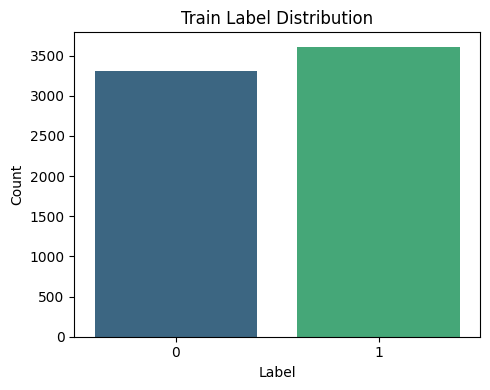

/tmp/ipython-input-682704884.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["label"], palette="viridis")


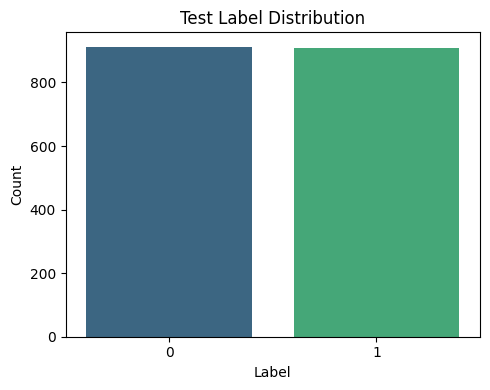

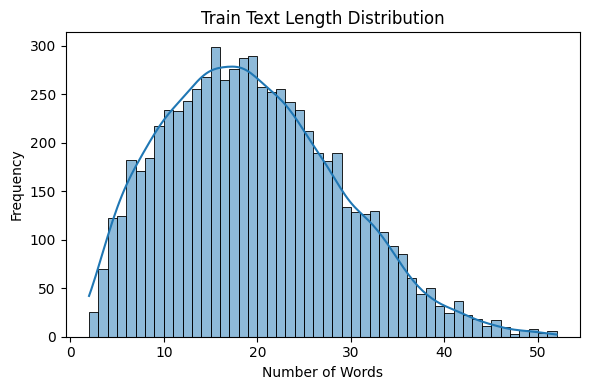

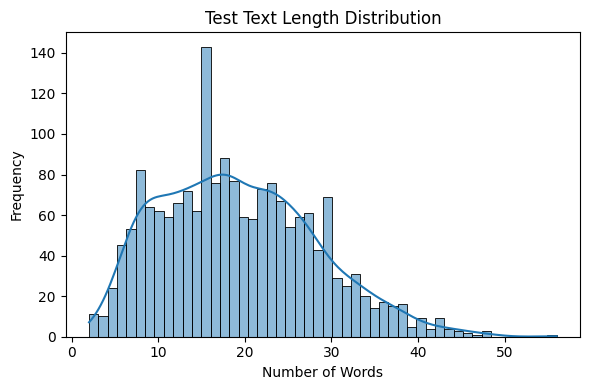

In [15]:
def load_stsa_file(path):
    labels = []
    texts  = []

    with open(path, "r", encoding="utf8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # Split only at first space
            label, text = line.split(" ", 1)

            labels.append(int(label))
            texts.append(text)

    return pd.DataFrame({"label": labels, "text": texts})


train_df = load_stsa_file("/content/stsa-train.txt")
test_df = load_stsa_file("/content/stsa-test.txt")

print(train_df.head())
print("Train size:", len(train_df))
print("Test size:", len(test_df))

def plot_class_distribution(df, title="Label Distribution"):
    plt.figure(figsize=(5, 4))
    sns.countplot(x=df["label"], palette="viridis")
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


def plot_length_distribution(df, title="Text Length Distribution"):
    lengths = df["text"].apply(lambda x: len(x.split()))

    plt.figure(figsize=(6, 4))
    sns.histplot(lengths, bins=50, kde=True, color="tab:blue")
    plt.title(title)
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_df, "Train Label Distribution")
plot_class_distribution(test_df, "Test Label Distribution")

plot_length_distribution(train_df, "Train Text Length Distribution")
plot_length_distribution(test_df, "Test Text Length Distribution")


In [16]:
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    if not isinstance(text, str):
      text = str(text) if text is not None else ""

    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(w)
        for w in tokens
        if w not in stop_words and len(w) > 2
    ]

    return " ".join(tokens)

train_df["clean"] = train_df["text"].apply(clean_text)
test_df["clean"] = test_df["text"].apply(clean_text)

X_train, X_val, y_train, y_val = train_test_split(
    train_df["clean"],
    train_df["label"],
    test_size=0.2,
    random_state=42
)

X_test = test_df["clean"]
y_test = test_df["label"]

tfidf = TfidfVectorizer(max_features=15000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

kf = KFold(n_splits=10, shuffle=True, random_state=42)


def cv_score(model, X, y):
    """Return mean F1 score from 10-fold cross-validation."""
    return cross_val_score(model, X, y, cv=kf, scoring="f1").mean()

results = {}


def evaluate(name, model, Xtr, ytr, Xte, yte):
    """Fit model → predict → compute metrics → store results."""
    model.fit(Xtr, ytr)
    preds = model.predict(Xte)

    acc = accuracy_score(yte, preds)

    prec, rec, f1, _ = precision_recall_fscore_support(
    yte, preds, average="macro", zero_division=0
)

    results[name] = [acc, prec, rec, f1]

    print(f"\n----- {name} -----")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")


In [17]:
xgb = XGBClassifier(eval_metric="logloss")
evaluate("XGBoost", xgb, X_train_tfidf, y_train, X_test_tfidf, y_test)

svm = LinearSVC()
evaluate("SVM", svm, X_train_tfidf, y_train, X_test_tfidf, y_test)

sentences = [t.split() for t in train_df["clean"]]
w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=2)

def avg_w2v(text):
    words = text.split()
    vecs = [w2v.wv[w] for w in words if w in w2v.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

X_train_w2v = np.array([avg_w2v(t) for t in X_train])
X_test_w2v = np.array([avg_w2v(t) for t in X_test])

w2v_clf = LogisticRegression(max_iter=200)
evaluate("Word2Vec", w2v_clf, X_train_w2v, y_train, X_test_w2v, y_test)

rf = RandomForestClassifier(n_estimators=300)
evaluate("Random Forest", rf, X_train_tfidf, y_train, X_test_tfidf, y_test)

tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

pipeline = TextClassificationPipeline(
    model=bert_model, tokenizer=tokenizer, truncation=True
)

bert_preds = []
for text in test_df["text"]:
    label = pipeline(text)[0]["label"]   # POSITIVE / NEGATIVE
    bert_preds.append(1 if label == "POSITIVE" else 0)

bert_preds = np.array(bert_preds)

acc = accuracy_score(y_test, bert_preds)

prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, bert_preds, average="macro", zero_division=0
)


results["BERT"] = [acc, prec, rec, f1]

print("\n----- BERT Pretrained -----")
print(f"Accuracy : {acc}")
print(f"Precision: {prec}")
print(f"Recall   : {rec}")
print(f"F1 Score : {f1}")


----- XGBoost -----
Accuracy  : 0.7024
Precision : 0.7097
Recall    : 0.7025
F1 Score  : 0.6998

----- SVM -----
Accuracy  : 0.7908
Precision : 0.7915
Recall    : 0.7908
F1 Score  : 0.7907

----- Word2Vec -----
Accuracy  : 0.4997
Precision : 0.7497
Recall    : 0.5005
F1 Score  : 0.3342

----- Random Forest -----
Accuracy  : 0.7512
Precision : 0.7515
Recall    : 0.7513
F1 Score  : 0.7512


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



----- BERT Pretrained -----
Accuracy : 0.9225700164744646
Precision: 0.9232455451525219
Recall   : 0.9226032800648486
F1 Score : 0.9225430143127137


In [18]:
results_df = pd.DataFrame(results, index=["Accuracy","Precision","Recall","F1"]).T

print(results_df)

               Accuracy  Precision    Recall        F1
XGBoost        0.702361   0.709696  0.702514  0.699837
SVM            0.790774   0.791479  0.790814  0.790663
Word2Vec       0.499725   0.749725  0.500548  0.334184
Random Forest  0.751236   0.751490  0.751261  0.751185
BERT           0.922570   0.923246  0.922603  0.922543


## **Question 3 (30 Points)**

# **Text Clustering**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)


1.   Perform EDA on selected dataset

2.   **Apply the listed clustering methods ( Any 4) to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

3. **Visualize the clusters**

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [19]:
file_path = "Amazon_Unlocked_Mobile.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "PromptCloudHQ/amazon-reviews-unlocked-mobile-phones",
  file_path,
)

df = df.sample(5000, random_state=42)

print("First 5 records:", df.head())

/tmp/ipython-input-3401307546.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'amazon-reviews-unlocked-mobile-phones' dataset.
First 5 records:                                              Product Name Brand Name   Price  \
54870   Apple iPhone 6 Plus 128GB Factory Unlocked GSM...        NaN  699.95   
188521  HTC Desire 816 Dual Sim Unlocked Smartphone (W...        HTC  221.00   
137548      BLU Studio 5.0 C HD Unlocked Cellphone, Black        BLU  173.44   
24906                  Apple iPhone 5c 16GB (Pink) - AT&T      Apple  519.00   
131601  BLU PURE XL Smartphone - 4G LTE GSM Unlocked -...        BLU  129.99   

        Rating                                            Reviews  \
54870        1  Defective phone. Works only for two days. Phon...   
188521       3                                               Cool   
137548       5                    Beautiful and excellent quality   
24906        2  Gave 3 stars because it did not come with a ch...   
131601       1  High resolution camera so you can zoom in afte...

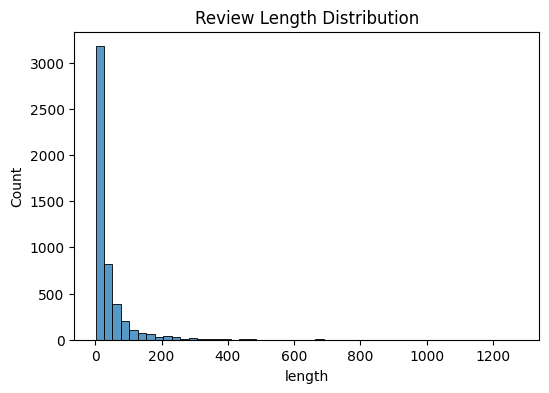

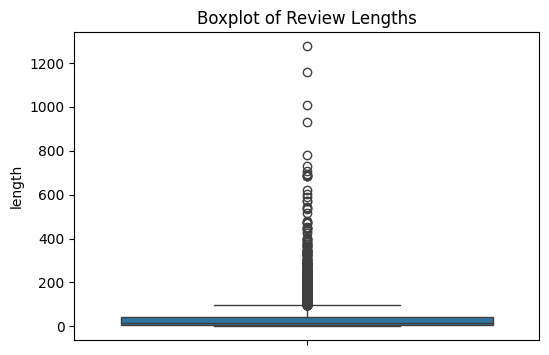

done cleaning
loaded tfidf
done tfidf


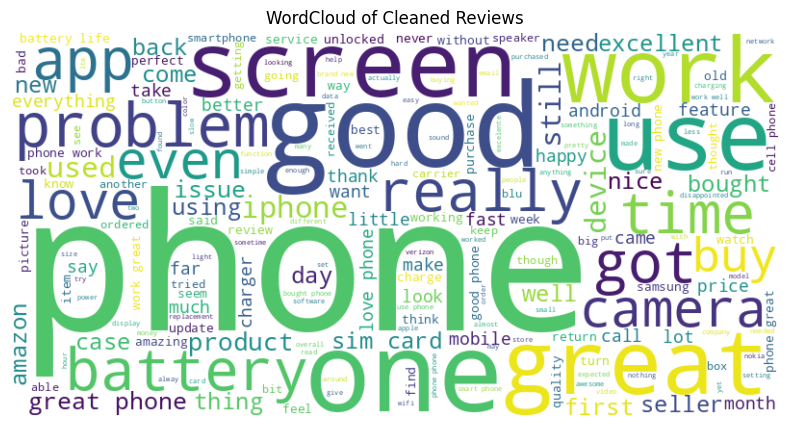

In [20]:
df["length"] = df["Reviews"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.histplot(df["length"], bins=50)
plt.title("Review Length Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(df["length"])
plt.title("Boxplot of Review Lengths")
plt.show()

df["clean"] = df["Reviews"].apply(clean_text)

print('done cleaning')
tfidf = TfidfVectorizer(max_features=1000)
print('loaded tfidf')
X_tfidf = tfidf.fit_transform(df["clean"])

print('done tfidf')

combined_text = " ".join(df['clean'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Cleaned Reviews")
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

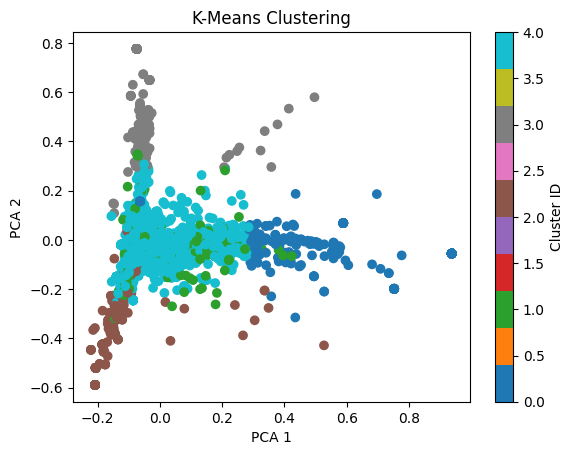

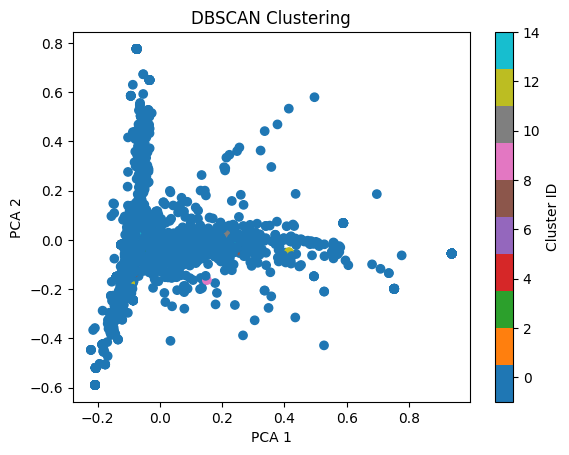

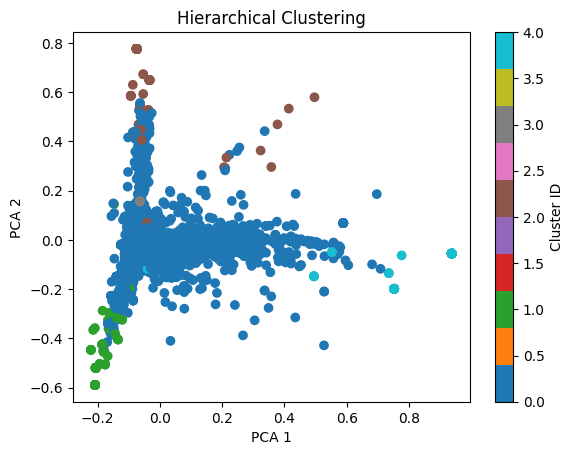

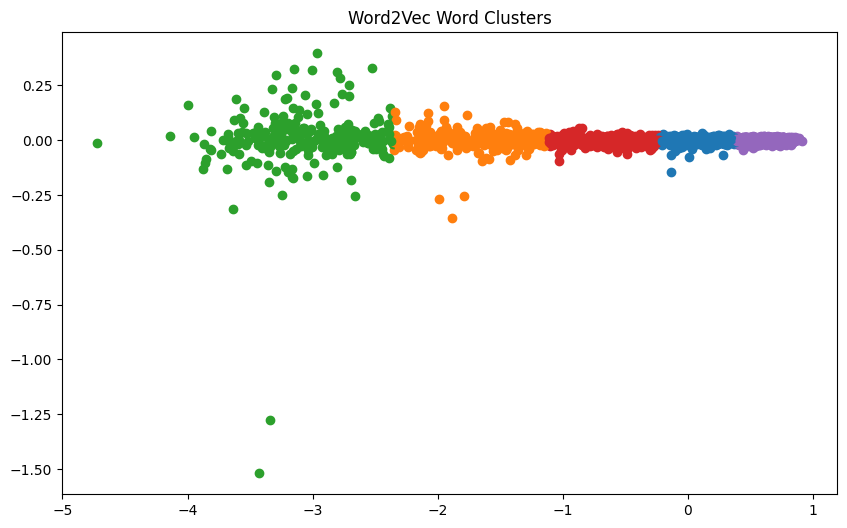

In [21]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_tfidf)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['kmeans_cluster'], cmap='tab10')
plt.title("K-Means Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster ID")
plt.show()

dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
df['dbscan_cluster'] = dbscan.fit_predict(X_tfidf)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['dbscan_cluster'], cmap='tab10')
plt.title("DBSCAN Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster ID")
plt.show()

agglo = AgglomerativeClustering(n_clusters=5)
df['hier_cluster'] = agglo.fit_predict(X_tfidf.toarray())

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['hier_cluster'], cmap='tab10')
plt.title("Hierarchical Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster ID")
plt.show()

# Tokenize sentences for Word2Vec
tokenized_sentences = df['clean'].apply(lambda x: x.split()).tolist()

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=2, workers=4)
word_vectors = [w2v_model.wv[word] for word in w2v_model.wv.index_to_key]

# Apply KMeans to word vectors
w2v_kmeans = KMeans(n_clusters=5, random_state=42)
w2v_labels = w2v_kmeans.fit_predict(word_vectors)

# Visualize Word2Vec Clusters
w2v_pca = PCA(n_components=2).fit_transform(word_vectors)
plt.figure(figsize=(10, 6))
for i, word in enumerate(w2v_model.wv.index_to_key):
    plt.scatter(w2v_pca[i, 0], w2v_pca[i, 1], c=f'C{w2v_labels[i]}')
plt.title("Word2Vec Word Clusters")
plt.show()


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

When we compare all the clustering results, we can see that K-means gives the cleanest and most balanced groups, since it works reasonably well with TF-IDF’s high-dimensional structure, even though it can oversimplify the relationships between reviews. DBSCAN, on the other hand, struggles with sparse text data and ends up putting almost everything in one cluster unless the parameters are tuned very carefully. Hierarchical clustering also produces heavily overlapping groups because it is sensitive to the distance metric and tends to merge most points together. Finally, the Word2Vec clusters look more meaningful because they are based on semantic embeddings, allowing words with similar usage and context to group together more naturally than the traditional TF-IDF–based methods.


# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises and on Teaching Assistant by filling this form:

https://docs.google.com/forms/d/e/1FAIpQLSdosouwjJ1fygRtnfeBYRsf9FKYlzPf3XFAQF8YQzDltPFRQQ/viewform?usp=dialog

**(Your submission will not be graded if this question is left unanswered)**

